In [1]:
# NLP: алгоритмы и подходы.

In [2]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 1. Подготовка данных
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 2. Загрузка данных
data = {
    'text': [
        'Этот продукт отличный, очень доволен!',
        'Ужасный сервис, никогда не вернусь.',
        'Превосходное качество и быстрая доставка.',
        'Очень плохое качество, товар сломался через неделю.',
        'Отличное соотношение цены и качества.',
        'Не рекомендую, обслуживание оставляет желать лучшего.',
        'Замечательный магазин с хорошими товарами.',
        'Быстрая доставка, но товар не соответствует описанию.'
    ],
    'label': [1, 0, 1, 0, 1, 0, 1, 0]
}

df = pd.DataFrame(data)
X = df['text']
y = df['label']

# 3. Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 4. Инициализация токенизатора и создание датасетов
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

train_dataset = ReviewDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = ReviewDataset(X_test.tolist(), y_test.tolist(), tokenizer)

# 5. Создание загрузчиков данных
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2)

# 6. Инициализация модели
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# 7. Настройка оптимизатора
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

# 8. Обучение модели
epochs = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    print(f'Эпоха {epoch + 1}/{epochs} завершена.')

# 9. Оценка модели
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f'Точность модели: {accuracy * 100:.2f}%\n')
print('Отчет классификации:')
print(classification_report(true_labels, predictions, target_names=['Отрицательный', 'Положительный']))

# 10. Пример использования модели для новых данных
def predict_sentiment_bert(text):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).cpu().numpy()[0]
    return 'Положительный' if prediction == 1 else 'Отрицательный'

# Примеры
new_reviews = [
    'Очень доволен покупкой, все работает отлично!',
    'Товар пришел поврежденным, очень разочарован.'
]

for review in new_reviews:
    sentiment = predict_sentiment_bert(review)
    print(f'Отзыв: "{review}" - Тональность: {sentiment}')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Эпоха 1/3 завершена.
Эпоха 2/3 завершена.
Эпоха 3/3 завершена.
Точность модели: 0.00%

Отчет классификации:
               precision    recall  f1-score   support

Отрицательный       0.00      0.00      0.00       2.0
Положительный       0.00      0.00      0.00       0.0

     accuracy                           0.00       2.0
    macro avg       0.00      0.00      0.00       2.0
 weighted avg       0.00      0.00      0.00       2.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Отзыв: "Очень доволен покупкой, все работает отлично!" - Тональность: Положительный
Отзыв: "Товар пришел поврежденным, очень разочарован." - Тональность: Положительный


In [3]:
# https://huggingface.co/blanchefort/rubert-base-cased-sentiment

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

# 1. Инициализация предобученной модели и токенизатора
model_name = 'blanchefort/rubert-base-cased-sentiment'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# 2. Создание пайплайна для анализа тональности
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

# 3. Примеры использования
new_reviews = [
    'Очень доволен покупкой, все работает отлично!',
    'Товар пришел поврежденным, очень разочарован.'
]

for review in new_reviews:
    result = sentiment_pipeline(review)[0]
    label = result['label']
    score = result['score']
    print(f'Отзыв: "{review}" - Тональность: {label} (уверенность: {score:.2f})')


tokenizer_config.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/943 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

Отзыв: "Очень доволен покупкой, все работает отлично!" - Тональность: POSITIVE (уверенность: 0.98)
Отзыв: "Товар пришел поврежденным, очень разочарован." - Тональность: NEGATIVE (уверенность: 0.75)


In [5]:
 # Векторные представления слов. Word2Vec

In [6]:
!pip install gensim spacy matplotlib scikit-learn
!python -m spacy download ru_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 56.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
import spacy
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Загрузка русской модели spaCy
nlp = spacy.load('ru_core_news_sm')

# Пример текстового корпуса
corpus = [
    "Обработка естественного языка — это область искусственного интеллекта.",
    "Word2Vec — популярный метод для создания векторных представлений слов.",
    "Машинное обучение используется для анализа больших объемов данных.",
    "Нейронные сети особенно эффективны в задачах распознавания образов.",
    "Трансформеры изменили подходы к обработке последовательных данных.",
    "Глубокое обучение позволяет моделям обучаться на больших наборах данных.",
    "Представления слов захватывают семантические свойства терминов.",
    "Натуральный язык является сложной и богатой структурой.",
    "Классификация текста включает в себя анализ тональности и тематическое моделирование.",
    "Распознавание именованных сущностей выделяет ключевые элементы в тексте."
]

# Функция предобработки текста
def preprocess(text):
    """
    Предобработка текста: приведение к нижнему регистру, токенизация,
    удаление стоп-слов и пунктуации.
    """
    doc = nlp(text.lower())
    tokens = [token.text for token in doc if token.is_alpha and not token.is_stop]
    return tokens

# Применение предобработки к корпусу
processed_corpus = [preprocess(doc) for doc in corpus]
print("Предобработанный корпус:")
for doc in processed_corpus:
    print(doc)


Предобработанный корпус:
['обработка', 'естественного', 'языка', 'область', 'искусственного', 'интеллекта']
['популярный', 'метод', 'создания', 'векторных', 'представлений', 'слов']
['машинное', 'обучение', 'используется', 'анализа', 'больших', 'объемов']
['нейронные', 'сети', 'эффективны', 'задачах', 'распознавания', 'образов']
['трансформеры', 'изменили', 'подходы', 'обработке', 'последовательных']
['глубокое', 'обучение', 'позволяет', 'моделям', 'обучаться', 'больших', 'наборах']
['представления', 'слов', 'захватывают', 'семантические', 'свойства', 'терминов']
['натуральный', 'язык', 'является', 'сложной', 'богатой', 'структурой']
['классификация', 'текста', 'включает', 'анализ', 'тональности', 'тематическое', 'моделирование']
['распознавание', 'именованных', 'сущностей', 'выделяет', 'ключевые', 'элементы', 'тексте']


In [8]:
# Обучение модели Word2Vec
# Параметры модели Word2Vec
vector_size = 100  # Размерность векторов
window = 5         # Размер окна контекста
min_count = 1      # Минимальное количество вхождений слова
workers = 4        # Количество потоков для обучения

# Обучение модели Word2Vec
model = Word2Vec(sentences=processed_corpus, vector_size=vector_size, window=window, min_count=min_count, workers=workers)

# Сохранение модели (опционально)
model.save("word2vec_ru.model")
# Загрузка модели (опционально)
# model = Word2Vec.load("word2vec_ru.model")


In [9]:
# Использование модели
# Получение вектора для слова
word = 'обучение'
try:
    vector = model.wv[word]
    print(f"\nВектор слова '{word}':\n{vector}\n")
except KeyError:
    print(f"\nСлово '{word}' отсутствует в словаре модели.")



Вектор слова 'обучение':
[-5.3156674e-04  2.3777726e-04  5.1030354e-03  9.0095913e-03
 -9.3042208e-03 -7.1170209e-03  6.4603547e-03  8.9779049e-03
 -5.0200010e-03 -3.7627514e-03  7.3821940e-03 -1.5346573e-03
 -4.5301556e-03  6.5545510e-03 -4.8594098e-03 -1.8183675e-03
  2.8798608e-03  9.8911393e-04 -8.2866261e-03 -9.4536496e-03
  7.3128305e-03  5.0687422e-03  6.7595919e-03  7.6056208e-04
  6.3497541e-03 -3.4079964e-03 -9.4655919e-04  5.7712742e-03
 -7.5215325e-03 -3.9345869e-03 -7.5110914e-03 -9.3244720e-04
  9.5401704e-03 -7.3198020e-03 -2.3342993e-03 -1.9360428e-03
  8.0785714e-03 -5.9327558e-03  4.1939875e-05 -4.7552478e-03
 -9.6078124e-03  5.0085033e-03 -8.7594036e-03 -4.3898504e-03
 -3.6509682e-05 -2.9585569e-04 -7.6601813e-03  9.6132550e-03
  4.9794759e-03  9.2342785e-03 -8.1609720e-03  4.4927234e-03
 -4.1398741e-03  8.2202454e-04  8.4998375e-03 -4.4655707e-03
  4.5169811e-03 -6.7854733e-03 -3.5486328e-03  9.3999999e-03
 -1.5774247e-03  3.1537385e-04 -4.1374937e-03 -7.6815644e-0

In [10]:
# Поиск схожих слов
# Нахождение 5 наиболее схожих слов
similar_words = model.wv.most_similar('обучение', topn=5)
print(f"Схожие слова с '{word}':")
for similar_word, similarity in similar_words:
    print(f"  {similar_word}: {similarity:.4f}")


Схожие слова с 'обучение':
  последовательных: 0.2190
  задачах: 0.2162
  обработке: 0.1955
  захватывают: 0.1722
  классификация: 0.1693


In [11]:
# Векторная арифметика (аналогии)
# Пример аналогии: 'обучение' - 'машинное' + 'искусственного' = ?
try:
    analogy = model.wv.most_similar(positive=['обучение', 'искусственного'], negative=['машинное'], topn=1)
    print(f"\nАналогия: 'обучение' - 'машинное' + 'искусственного' = {analogy[0][0]} (с похожестью {analogy[0][1]:.4f})")
except KeyError as e:
    print(f"\nОшибка: {e}")



Аналогия: 'обучение' - 'машинное' + 'искусственного' = задачах (с похожестью 0.2221)


In [12]:
# Вычисление схожести между двумя словами
# Схожесть между двумя словами
word1 = 'обучение'
word2 = 'машинное'
try:
    similarity = model.wv.similarity(word1, word2)
    print(f"\nСхожесть между '{word1}' и '{word2}': {similarity:.4f}")
except KeyError as e:
    print(f"\nОшибка: {e}")



Схожесть между 'обучение' и 'машинное': -0.1140


In [13]:
# Word2Vec: CBOW.

Предобработанный корпус:
['обработка', 'естественного', 'языка', 'область', 'искусственного', 'интеллекта']
['популярный', 'метод', 'создания', 'векторных', 'представлений', 'слов']
['машинное', 'обучение', 'используется', 'анализа', 'больших', 'объемов']
['нейронные', 'сети', 'эффективны', 'задачах', 'распознавания', 'образов']
['трансформеры', 'изменили', 'подходы', 'обработке', 'последовательных']
['глубокое', 'обучение', 'позволяет', 'моделям', 'обучаться', 'больших', 'наборах']
['представления', 'слов', 'захватывают', 'семантические', 'свойства', 'терминов']
['натуральный', 'язык', 'является', 'сложной', 'богатой', 'структурой']
['классификация', 'текста', 'включает', 'анализ', 'тональности', 'тематическое', 'моделирование']
['распознавание', 'именованных', 'сущностей', 'выделяет', 'ключевые', 'элементы', 'тексте']

Вектор слова 'обучение':
[-5.3156674e-04  2.3777726e-04  5.1030354e-03  9.0095913e-03
 -9.3042208e-03 -7.1170209e-03  6.4603547e-03  8.9779049e-03
 -5.0200010e-03 -3.7

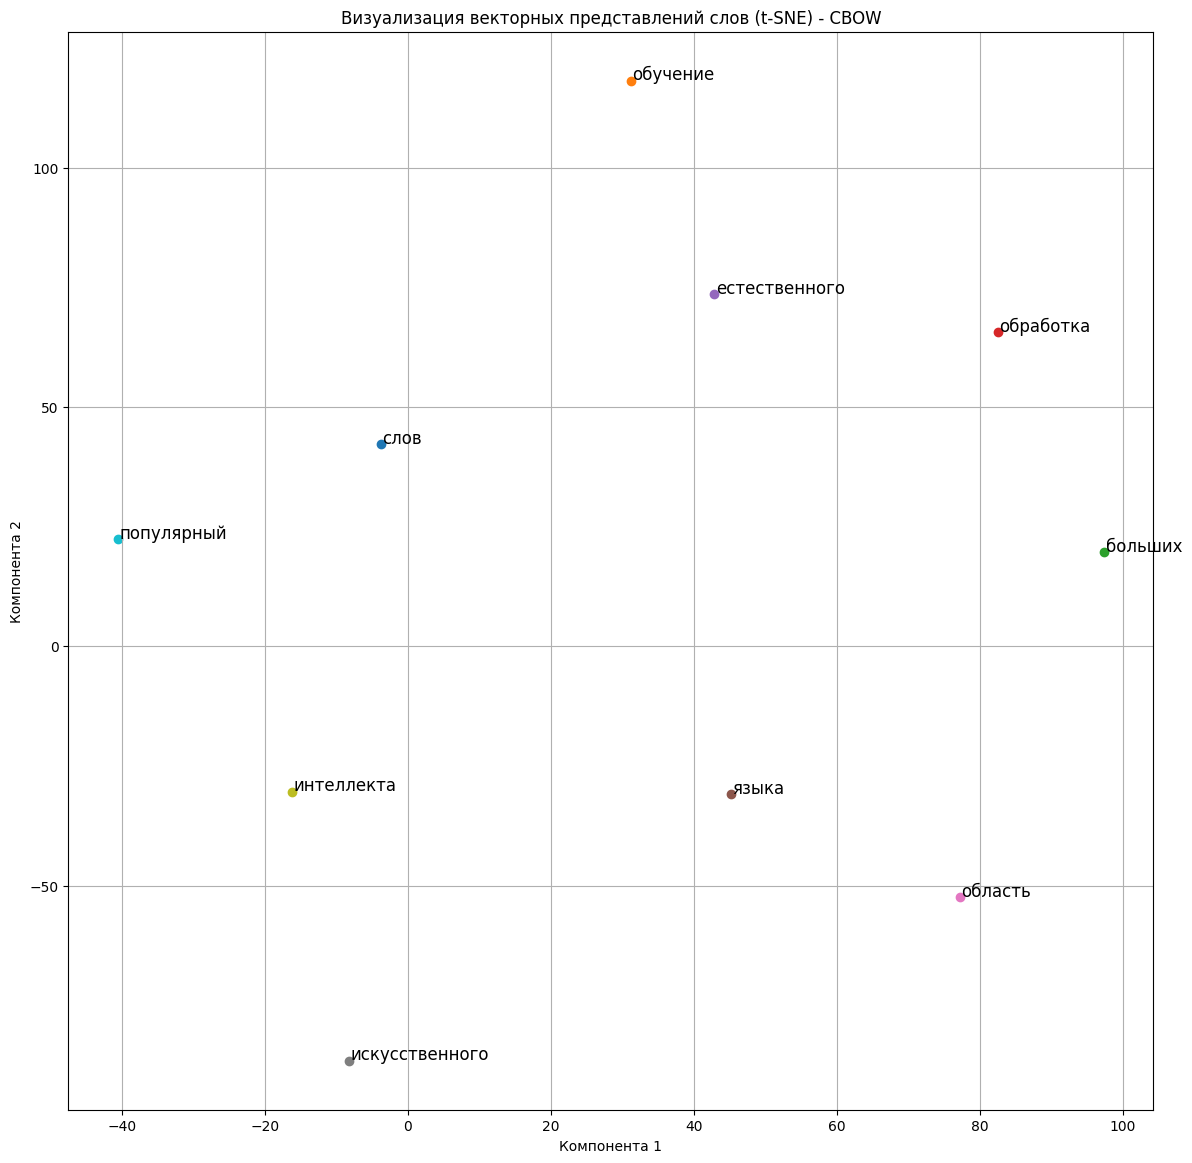

In [14]:
import spacy
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import Counter
import numpy as np
import plotly.express as px
import umap

# Загрузка русской модели spaCy
nlp = spacy.load('ru_core_news_sm')

# Пример текстового корпуса
corpus = [
    "Обработка естественного языка — это область искусственного интеллекта.",
    "Word2Vec — популярный метод для создания векторных представлений слов.",
    "Машинное обучение используется для анализа больших объемов данных.",
    "Нейронные сети особенно эффективны в задачах распознавания образов.",
    "Трансформеры изменили подходы к обработке последовательных данных.",
    "Глубокое обучение позволяет моделям обучаться на больших наборах данных.",
    "Представления слов захватывают семантические свойства терминов.",
    "Натуральный язык является сложной и богатой структурой.",
    "Классификация текста включает в себя анализ тональности и тематическое моделирование.",
    "Распознавание именованных сущностей выделяет ключевые элементы в тексте."
]

# Функция предобработки текста
def preprocess(text):
    """
    Предобработка текста: приведение к нижнему регистру, токенизация,
    удаление стоп-слов и пунктуации.
    """
    doc = nlp(text.lower())
    tokens = [token.text for token in doc if token.is_alpha and not token.is_stop]
    return tokens

# Применение предобработки к корпусу
processed_corpus = [preprocess(doc) for doc in corpus]
print("Предобработанный корпус:")
for doc in processed_corpus:
    print(doc)

# Обучение модели Word2Vec с использованием CBOW
vector_size = 100
window = 5
min_count = 1
workers = 4
sg = 0  # CBOW

model_cbow = Word2Vec(sentences=processed_corpus,
                      vector_size=vector_size,
                      window=window,
                      min_count=min_count,
                      workers=workers,
                      sg=sg)

# Получение вектора для слова
word = 'обучение'
try:
    vector = model_cbow.wv[word]
    print(f"\nВектор слова '{word}':\n{vector}\n")
except KeyError:
    print(f"\nСлово '{word}' отсутствует в словаре модели.")

# Нахождение 5 наиболее схожих слов
similar_words = model_cbow.wv.most_similar('обучение', topn=5)
print(f"Схожие слова с '{word}':")
for similar_word, similarity in similar_words:
    print(f"  {similar_word}: {similarity:.4f}")

# Векторная арифметика (аналогии)
try:
    analogy = model_cbow.wv.most_similar(positive=['обучение', 'искусственного'], negative=['машинное'], topn=1)
    print(f"\nАналогия: 'обучение' - 'машинное' + 'искусственного' = {analogy[0][0]} (с похожестью {analogy[0][1]:.4f})")
except KeyError as e:
    print(f"\nОшибка: {e}")

# Схожесть между двумя словами
word1 = 'обучение'
word2 = 'машинное'
try:
    similarity = model_cbow.wv.similarity(word1, word2)
    print(f"\nСхожесть между '{word1}' и '{word2}': {similarity:.4f}")
except KeyError as e:
    print(f"\nОшибка: {e}")

# Функция для визуализации с использованием t-SNE
def plot_tsne(model, words, perplexity=5, max_iter=3000):
    """
    Визуализация векторных представлений слов с использованием t-SNE.

    :param model: Обученная модель Word2Vec.
    :param words: Список слов для визуализации.
    :param perplexity: Параметр perplexity для t-SNE. Должен быть меньше количества слов.
    :param max_iter: Максимальное количество итераций для t-SNE.
    """
    # Проверка, что perplexity меньше количества слов
    if perplexity >= len(words):
        raise ValueError(f"perplexity must be less than number of words ({len(words)}).")

    # Получение векторов слов и преобразование в массив NumPy
    word_vectors = np.array([model.wv[word] for word in words])

    # Инициализация t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, max_iter=max_iter, random_state=42)

    # Применение t-SNE к векторным представлениям слов
    tsne_results = tsne.fit_transform(word_vectors)

    # Создание графика
    plt.figure(figsize=(14, 14))
    for i, word in enumerate(words):
        plt.scatter(tsne_results[i, 0], tsne_results[i, 1])
        plt.annotate(word, (tsne_results[i, 0]+0.2, tsne_results[i, 1]+0.2), fontsize=12)
    plt.title("Визуализация векторных представлений слов (t-SNE) - CBOW")
    plt.xlabel("Компонента 1")
    plt.ylabel("Компонента 2")
    plt.grid(True)
    plt.show()

# Выбор топ-10 наиболее частотных слов для визуализации
word_counts = Counter([word for sentence in processed_corpus for word in sentence])
most_common_words = [word for word, count in word_counts.most_common(10)]

# Визуализация с использованием t-SNE с перплексией 5
plot_tsne(model_cbow, most_common_words, perplexity=5)

# Функция для интерактивной визуализации с Plotly и t-SNE
def plot_interactive_tsne(model, words, perplexity=5, max_iter=3000):
    """
    Интерактивная визуализация векторных представлений слов с использованием t-SNE и Plotly.

    :param model: Обученная модель Word2Vec.
    :param words: Список слов для визуализации.
    :param perplexity: Параметр perplexity для t-SNE.
    :param max_iter: Максимальное количество итераций для t-SNE.
    """
    if perplexity >= len(words):
        raise ValueError(f"perplexity must be less than number of words ({len(words)}).")

    word_vectors = np.array([model.wv[word] for word in words])
    tsne = TSNE(n_components=2, perplexity=perplexity, max_iter=max_iter, random_state=42)
    tsne_results = tsne.fit_transform(word_vectors)

    df = pd.DataFrame({
        'word': words,
        'x': tsne_results[:, 0],
        'y': tsne_results[:, 1]
    })

    fig = px.scatter(df, x='x', y='y', text='word', title='Визуализация векторных представлений слов (t-SNE) - CBOW')
    fig.update_traces(textposition='top center')
    fig.update_layout(showlegend=False, width=800, height=800)
    fig.show()

# Интерактивная визуализация топ-10 слов
plot_interactive_tsne(model_cbow, most_common_words, perplexity=5)


In [15]:
# Word2Vec: Skip-Gram.

In [16]:
!python -m spacy download ru_core_news_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/ru_core_news_sm-3.7.0/ru_core_news_sm-3.7.0-py3-none-any.whl (15.3 MB)
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Предобработанный корпус:
['обработка', 'естественного', 'языка', 'область', 'искусственного', 'интеллекта']
['популярный', 'метод', 'создания', 'векторных', 'представлений', 'слов']
['машинное', 'обучение', 'используется', 'анализа', 'больших', 'объемов']
['нейронные', 'сети', 'эффективны', 'задачах', 'распознавания', 'образов']
['трансформеры', 'изменили', 'подходы', 'обработке', 'последовательных']
['глубокое', 'обучение', 'позволяет', 'моделям', 'обучаться', 'больших', 'наборах']
['представления', 'слов', 'захватывают', 'семантические', 'свойства', 'терминов']
['натуральный', 'язык', 'является', 'сложной', 'богатой', 'структурой']
['классификация', 'текста', 'включает', 'анализ', 'тональности', 'тематическое', 'моделирование']
['распознавание', 'именованных', 'сущностей', 'выделяет', 'ключевые', 'элементы', 'тексте']

Вектор слова 'обучение':
[-5.3553301e-04  2.3251191e-04  5.0971569e-03  9.0045594e-03
 -9.2990380e-03 -7.1181529e-03  6.4566154e-03  8.9790141e-03
 -5.0150934e-03 -3.7

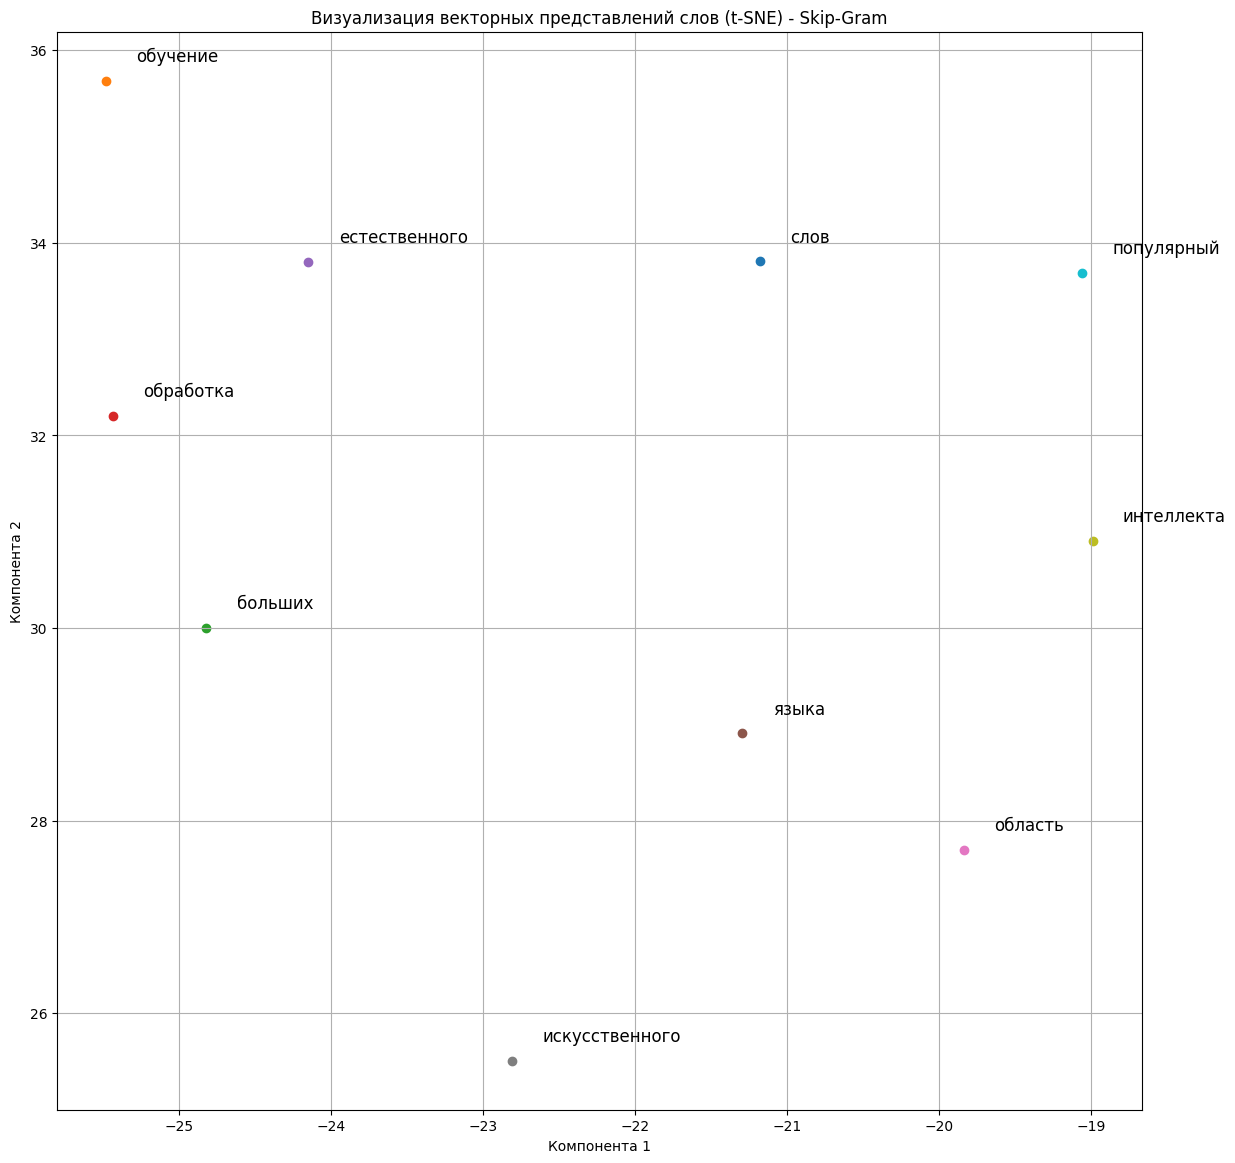

In [17]:
import spacy
import pandas as pd
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import Counter
import numpy as np
import plotly.express as px

# Загрузка русской модели spaCy
nlp = spacy.load('ru_core_news_sm')

# Пример текстового корпуса
corpus = [
    "Обработка естественного языка — это область искусственного интеллекта.",
    "Word2Vec — популярный метод для создания векторных представлений слов.",
    "Машинное обучение используется для анализа больших объемов данных.",
    "Нейронные сети особенно эффективны в задачах распознавания образов.",
    "Трансформеры изменили подходы к обработке последовательных данных.",
    "Глубокое обучение позволяет моделям обучаться на больших наборах данных.",
    "Представления слов захватывают семантические свойства терминов.",
    "Натуральный язык является сложной и богатой структурой.",
    "Классификация текста включает в себя анализ тональности и тематическое моделирование.",
    "Распознавание именованных сущностей выделяет ключевые элементы в тексте."
]

# Функция предобработки текста
def preprocess(text):
    """
    Предобработка текста: приведение к нижнему регистру, токенизация,
    удаление стоп-слов и пунктуации.
    """
    doc = nlp(text.lower())
    tokens = [token.text for token in doc if token.is_alpha and not token.is_stop]
    return tokens

# Применение предобработки к корпусу
processed_corpus = [preprocess(doc) for doc in corpus]
print("Предобработанный корпус:")
for doc in processed_corpus:
    print(doc)

# Обучение модели Word2Vec с использованием Skip-Gram
vector_size = 100
window = 5
min_count = 1
workers = 4
sg = 1  # 1 для Skip-gram, 0 для CBOW

model_skipgram = Word2Vec(sentences=processed_corpus,
                          vector_size=vector_size,
                          window=window,
                          min_count=min_count,
                          workers=workers,
                          sg=sg)

# Получение вектора для слова
word = 'обучение'
try:
    vector = model_skipgram.wv[word]
    print(f"\nВектор слова '{word}':\n{vector}\n")
except KeyError:
    print(f"\nСлово '{word}' отсутствует в словаре модели.")

# Нахождение 5 наиболее схожих слов
similar_words = model_skipgram.wv.most_similar('обучение', topn=5)
print(f"Схожие слова с '{word}':")
for similar_word, similarity in similar_words:
    print(f"  {similar_word}: {similarity:.4f}")

# Векторная арифметика (аналогии)
try:
    analogy = model_skipgram.wv.most_similar(positive=['обучение', 'искусственного'], negative=['машинное'], topn=1)
    print(f"\nАналогия: 'обучение' - 'машинное' + 'искусственного' = {analogy[0][0]} (с похожестью {analogy[0][1]:.4f})")
except KeyError as e:
    print(f"\nОшибка: {e}")

# Схожесть между двумя словами
word1 = 'обучение'
word2 = 'машинное'
try:
    similarity = model_skipgram.wv.similarity(word1, word2)
    print(f"\nСхожесть между '{word1}' и '{word2}': {similarity:.4f}")
except KeyError as e:
    print(f"\nОшибка: {e}")

# Функция для визуализации с использованием t-SNE
def plot_tsne(model, words, perplexity=5, max_iter=3000):
    """
    Визуализация векторных представлений слов с использованием t-SNE.

    :param model: Обученная модель Word2Vec.
    :param words: Список слов для визуализации.
    :param perplexity: Параметр perplexity для t-SNE. Должен быть меньше количества слов.
    :param max_iter: Максимальное количество итераций для t-SNE.
    """
    # Проверка, что perplexity меньше количества слов
    if perplexity >= len(words):
        raise ValueError(f"perplexity must be less than number of words ({len(words)}).")

    # Получение векторов слов и преобразование в массив NumPy
    word_vectors = np.array([model.wv[word] for word in words])

    # Инициализация t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, max_iter=max_iter, random_state=42)

    # Применение t-SNE к векторным представлениям слов
    tsne_results = tsne.fit_transform(word_vectors)

    # Создание графика
    plt.figure(figsize=(14, 14))
    for i, word in enumerate(words):
        plt.scatter(tsne_results[i, 0], tsne_results[i, 1])
        plt.annotate(word, (tsne_results[i, 0]+0.2, tsne_results[i, 1]+0.2), fontsize=12)
    plt.title("Визуализация векторных представлений слов (t-SNE) - Skip-Gram")
    plt.xlabel("Компонента 1")
    plt.ylabel("Компонента 2")
    plt.grid(True)
    plt.show()

# Функция для интерактивной визуализации с Plotly и t-SNE
def plot_interactive_tsne(model, words, perplexity=5, max_iter=3000):
    """
    Интерактивная визуализация векторных представлений слов с использованием t-SNE и Plotly.

    :param model: Обученная модель Word2Vec.
    :param words: Список слов для визуализации.
    :param perplexity: Параметр perplexity для t-SNE.
    :param max_iter: Максимальное количество итераций для t-SNE.
    """
    if perplexity >= len(words):
        raise ValueError(f"perplexity must be less than number of words ({len(words)}).")

    word_vectors = np.array([model.wv[word] for word in words])
    tsne = TSNE(n_components=2, perplexity=perplexity, max_iter=max_iter, random_state=42)
    tsne_results = tsne.fit_transform(word_vectors)

    df = pd.DataFrame({
        'word': words,
        'x': tsne_results[:, 0],
        'y': tsne_results[:, 1]
    })

    fig = px.scatter(df, x='x', y='y', text='word', title='Визуализация векторных представлений слов (t-SNE) - Skip-Gram')
    fig.update_traces(textposition='top center')
    fig.update_layout(showlegend=False, width=800, height=800)
    fig.show()

# Выбор топ-10 наиболее частотных слов для визуализации
word_counts = Counter([word for sentence in processed_corpus for word in sentence])
most_common_words = [word for word, count in word_counts.most_common(10)]

# Визуализация с использованием t-SNE с перплексией 5
plot_tsne(model_skipgram, most_common_words, perplexity=5)


# Интерактивная визуализация топ-10 слов
plot_interactive_tsne(model_skipgram, most_common_words, perplexity=5)


In [18]:
# FastText

In [19]:
!pip install gensim spacy matplotlib plotly umap-learn
!python -m spacy download ru_core_news_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/ru_core_news_sm-3.7.0/ru_core_news_sm-3.7.0-py3-none-any.whl (15.3 MB)
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Модель 'ru_core_news_sm' успешно загружена!

Предобработанный корпус:
['обработка', 'естественного', 'языка', 'область', 'искусственного', 'интеллекта']
['fasttext', 'мощный', 'инструмент', 'создания', 'векторных', 'представлений', 'слов']
['машинное', 'обучение', 'используется', 'анализа', 'больших', 'объемов']
['нейронные', 'сети', 'эффективны', 'задачах', 'распознавания', 'образов']
['трансформеры', 'изменили', 'подходы', 'обработке', 'последовательных']
['глубокое', 'обучение', 'позволяет', 'моделям', 'обучаться', 'больших', 'наборах']
['представления', 'слов', 'захватывают', 'семантические', 'свойства', 'терминов']
['натуральный', 'язык', 'является', 'сложной', 'богатой', 'структурой']
['классификация', 'текста', 'включает', 'анализ', 'тональности', 'тематическое', 'моделирование']
['распознавание', 'именованных', 'сущностей', 'выделяет', 'ключевые', 'элементы', 'тексте']

Вектор слова 'обучение':
[-2.4088626e-03  1.6947099e-03 -1.1963858e-03 -5.2423024e-04
  1.0762236e-03 -8.4373

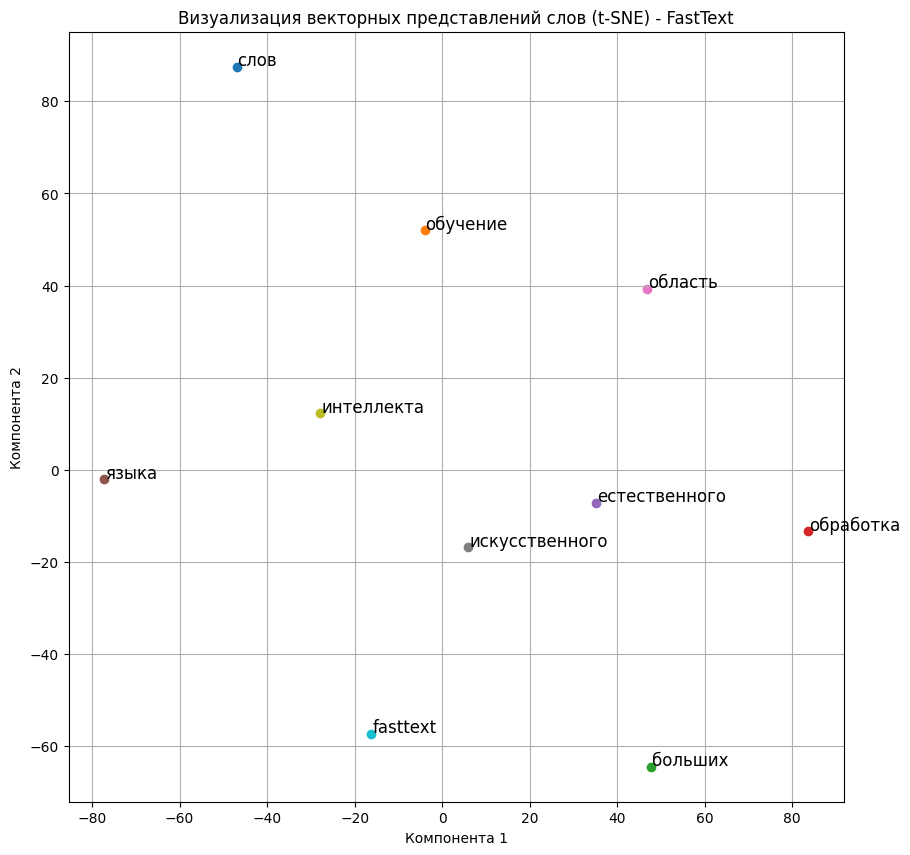

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:2462: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



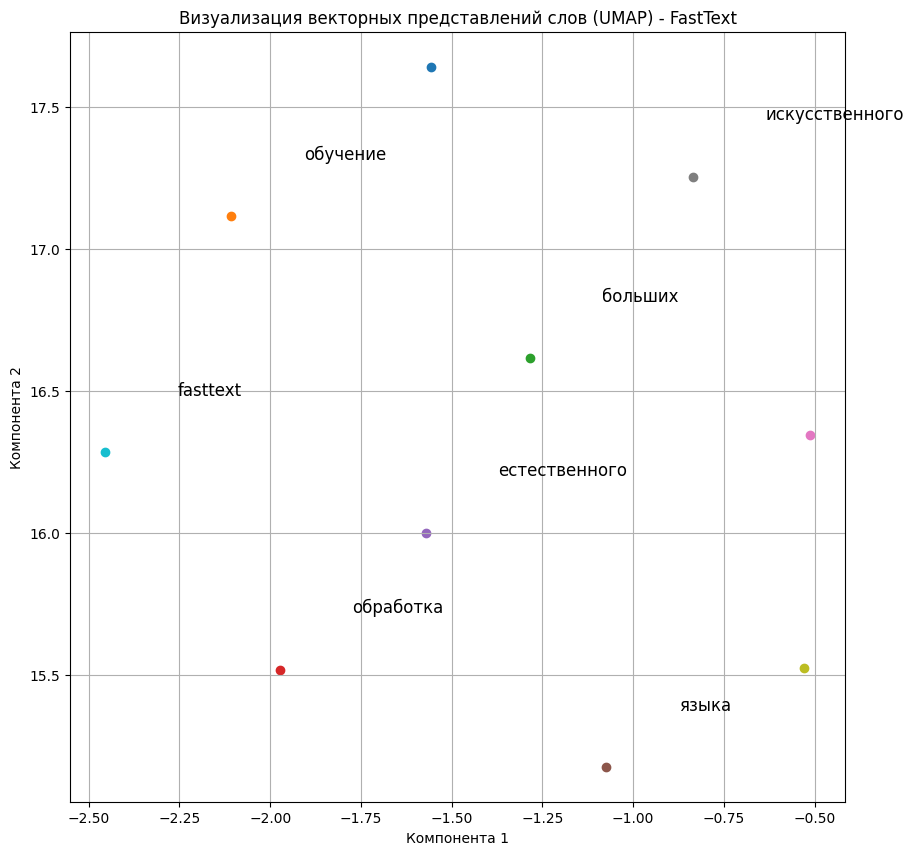

In [20]:
import spacy
from gensim.models import FastText
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import Counter
import numpy as np
import plotly.express as px
import umap
import pandas as pd

# Шаг 2: Загрузка русской модели spaCy
try:
    nlp = spacy.load('ru_core_news_sm')
    print("Модель 'ru_core_news_sm' успешно загружена!")
except OSError:
    print("Модель 'ru_core_news_sm' не найдена. Устанавливаем модель...")
    # Раскомментируйте следующую строку для автоматической установки модели
    # !python -m spacy download ru_core_news_sm
    nlp = spacy.load('ru_core_news_sm')

# Шаг 3: Пример текстового корпуса
corpus = [
    "Обработка естественного языка — это область искусственного интеллекта.",
    "FastText — мощный инструмент для создания векторных представлений слов.",
    "Машинное обучение используется для анализа больших объемов данных.",
    "Нейронные сети особенно эффективны в задачах распознавания образов.",
    "Трансформеры изменили подходы к обработке последовательных данных.",
    "Глубокое обучение позволяет моделям обучаться на больших наборах данных.",
    "Представления слов захватывают семантические свойства терминов.",
    "Натуральный язык является сложной и богатой структурой.",
    "Классификация текста включает в себя анализ тональности и тематическое моделирование.",
    "Распознавание именованных сущностей выделяет ключевые элементы в тексте."
]

# Шаг 4: Функция предобработки текста
def preprocess(text):
    """
    Предобработка текста: приведение к нижнему регистру, токенизация,
    удаление стоп-слов и пунктуации.
    """
    doc = nlp(text.lower())
    tokens = [token.text for token in doc if token.is_alpha and not token.is_stop]
    return tokens

# Применение предобработки к корпусу
processed_corpus = [preprocess(doc) for doc in corpus]
print("\nПредобработанный корпус:")
for doc in processed_corpus:
    print(doc)

# Шаг 5: Обучение модели FastText
# Обучение модели FastText
model = FastText(sentences=processed_corpus, vector_size=100, window=5, min_count=1, workers=4, sg=1, epochs=30)

# Сохранение модели (опционально)
model.save("fasttext.model")

# Загрузка модели (опционально)
# model = FastText.load("fasttext.model")

# Шаг 6: Использование обученной модели

# 6.1. Получение вектора для слова
word = 'обучение'
if word in model.wv:
    vector = model.wv[word]
    print(f"\nВектор слова '{word}':\n{vector}\n")
else:
    print(f"\nСлово '{word}' отсутствует в словаре модели.")

# 6.2. Нахождение схожих слов
similar_words = model.wv.most_similar(word, topn=5)
print(f"Схожие слова с '{word}':")
for similar_word, similarity in similar_words:
    print(f"  {similar_word}: {similarity:.4f}")

# 6.3. Векторная арифметика (аналогии)
try:
    analogy = model.wv.most_similar(positive=['обучение', 'искусственного'], negative=['машинное'], topn=1)
    print(f"\nАналогия: 'обучение' - 'машинное' + 'искусственного' = {analogy[0][0]} (с похожестью {analogy[0][1]:.4f})")
except KeyError as e:
    print(f"\nОшибка: {e}")

# 6.4. Вычисление схожести между двумя словами
word1 = 'обучение'
word2 = 'машинное'
if word1 in model.wv and word2 in model.wv:
    similarity = model.wv.similarity(word1, word2)
    print(f"\nСхожесть между '{word1}' и '{word2}': {similarity:.4f}")
else:
    print(f"\nОдно из слов '{word1}' или '{word2}' отсутствует в словаре модели.")

# Шаг 7: Визуализация векторных представлений слов

# 7.1. Получение частотного распределения слов
word_counts = Counter([word for sentence in processed_corpus for word in sentence])

# 7.2. Выбор топ-10 наиболее частотных слов для визуализации
most_common_words = [word for word, count in word_counts.most_common(10)]
print(f"\nТоп-10 наиболее частотных слов для визуализации: {most_common_words}")

# 7.3. Функция для визуализации с использованием t-SNE
def plot_tsne(model, words, perplexity=5, max_iter=3000):
    """
    Визуализация векторных представлений слов с использованием t-SNE.

    :param model: Обученная модель FastText.
    :param words: Список слов для визуализации.
    :param perplexity: Параметр perplexity для t-SNE. Должен быть меньше количества слов.
    :param max_iter: Максимальное количество итераций для t-SNE.
    """
    if perplexity >= len(words):
        raise ValueError(f"perplexity must be less than number of words ({len(words)}).")

    # Проверка наличия слов в модели
    missing_words = [word for word in words if word not in model.wv]
    if missing_words:
        print(f"Внимание: следующие слова отсутствуют в модели и будут пропущены: {missing_words}")
        words = [word for word in words if word in model.wv]
        if not words:
            raise ValueError("Все слова отсутствуют в модели.")

    # Получение векторов слов и преобразование в numpy массив
    word_vectors = np.array([model.wv[word] for word in words])

    # Применение t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, max_iter=max_iter, random_state=42)
    tsne_results = tsne.fit_transform(word_vectors)

    # Построение графика
    plt.figure(figsize=(10, 10))
    for i, word in enumerate(words):
        plt.scatter(tsne_results[i, 0], tsne_results[i, 1])
        plt.annotate(word, (tsne_results[i, 0]+0.2, tsne_results[i, 1]+0.2), fontsize=12)
    plt.title("Визуализация векторных представлений слов (t-SNE) - FastText")
    plt.xlabel("Компонента 1")
    plt.ylabel("Компонента 2")
    plt.grid(True)
    plt.show()

# 7.4. Визуализация с использованием t-SNE с перплексией 5
plot_tsne(model, most_common_words, perplexity=5)

# 7.5. Функция для визуализации с использованием UMAP
def plot_umap(model, words, n_neighbors=15, min_dist=0.1, n_components=2):
    """
    Визуализация векторных представлений слов с использованием UMAP.

    :param model: Обученная модель FastText.
    :param words: Список слов для визуализации.
    :param n_neighbors: Параметр соседства для UMAP.
    :param min_dist: Минимальное расстояние между точками в UMAP.
    :param n_components: Количество измерений для снижения (обычно 2).
    """
    # Проверка наличия слов в модели
    missing_words = [word for word in words if word not in model.wv]
    if missing_words:
        print(f"Внимание: следующие слова отсутствуют в модели и будут пропущены: {missing_words}")
        words = [word for word in words if word in model.wv]
        if not words:
            raise ValueError("Все слова отсутствуют в модели.")

    # Получение векторов слов
    word_vectors = np.array([model.wv[word] for word in words])

    # Применение UMAP
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=42)
    umap_results = reducer.fit_transform(word_vectors)

    # Построение графика
    plt.figure(figsize=(10, 10))
    for i, word in enumerate(words):
        plt.scatter(umap_results[i, 0], umap_results[i, 1])
        plt.annotate(word, (umap_results[i, 0]+0.2, umap_results[i, 1]+0.2), fontsize=12)
    plt.title("Визуализация векторных представлений слов (UMAP) - FastText")
    plt.xlabel("Компонента 1")
    plt.ylabel("Компонента 2")
    plt.grid(True)
    plt.show()

# 7.6. Визуализация с использованием UMAP
plot_umap(model, most_common_words)

# 7.7. Функция для интерактивной визуализации с Plotly и t-SNE
def plot_interactive_tsne(model, words, perplexity=5, max_iter=3000):
    """
    Интерактивная визуализация векторных представлений слов с использованием t-SNE и Plotly.

    :param model: Обученная модель FastText.
    :param words: Список слов для визуализации.
    :param perplexity: Параметр perplexity для t-SNE.
    :param max_iter: Максимальное количество итераций для t-SNE.
    """
    if perplexity >= len(words):
        raise ValueError(f"perplexity must be less than number of words ({len(words)}).")

    # Проверка наличия слов в модели
    missing_words = [word for word in words if word not in model.wv]
    if missing_words:
        print(f"Внимание: следующие слова отсутствуют в модели и будут пропущены: {missing_words}")
        words = [word for word in words if word in model.wv]
        if not words:
            raise ValueError("Все слова отсутствуют в модели.")

    # Получение векторов слов и преобразование в numpy массив
    word_vectors = np.array([model.wv[word] for word in words])

    # Применение t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, max_iter=max_iter, random_state=42)
    tsne_results = tsne.fit_transform(word_vectors)

    # Создание DataFrame для Plotly
    df = pd.DataFrame({
        'word': words,
        'x': tsne_results[:, 0],
        'y': tsne_results[:, 1]
    })

    # Построение интерактивного графика
    fig = px.scatter(df, x='x', y='y', text='word', title='Визуализация векторных представлений слов (t-SNE) - FastText')
    fig.update_traces(textposition='top center')
    fig.update_layout(showlegend=False, width=800, height=800)
    fig.show()

# 7.8. Интерактивная визуализация с Plotly
plot_interactive_tsne(model, most_common_words, perplexity=5)
